In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import sys
import os

sys.path.append('..')
sys.path.append('../src')

import pandas as pd
import numpy as np
from datetime import timedelta

import constants as cst

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

from xgboost import XGBClassifier, plot_tree, plot_importance

In [33]:
training_data = pd.read_csv(os.path.join('..', cst.FEATURES_PATH), index_col=0)
training_target = pd.read_csv(os.path.join('..', cst.TRAIN_TARGET_PATH), index_col=0)

In [34]:
full_training_data = pd.merge(training_data, training_target, on='client_id', how='left')
full_training_data.dropna(inplace=True)

In [35]:
train_set, test_set = train_test_split(full_training_data, test_size=0.3, random_state=42)

## Extract label

In [36]:
y_train = train_set['is_churn']
train_set.drop(columns=['is_churn'], inplace=True)

y_test = test_set['is_churn']
test_set.drop(columns=['is_churn'], inplace=True)

## Transformer

In [37]:
scale_nume_cols = [
    'mean_qty',
    'mean_sales',
    'n_branch',
    'n_product',
    'purchase_freq',
    'n_purchases',
    # 'client_age',
    # 'time_from_last_purchase',
    # 'client_lifetime',
]
unscaled_num_cols = [
    'max_qty', 
    'min_qty', 
    'std_qty', 
    'last_qty_1',
    'last_qty_2',
    'last_qty_3',
    'last_qty_4',
    'max_sales',
    'min_sales', 
    'std_sales', 
    'last_sales_1',
    'last_sales_2',
    'last_sales_3',
    'last_sales_4', 
    'delay_purchase_n1',
    'delay_purchase_n2',
    'delay_purchase_n3',
    'delay_purchase_n4',
]
drop_cols = ['client_id', 'frequency', 'client_category', 'time_from_last_purchase', 'client_lifetime', 'client_age']

In [38]:
transformer = make_column_transformer(
    (StandardScaler(), scale_nume_cols),
    ('passthrough', unscaled_num_cols),
    ('drop', drop_cols)
)

## Fitting model

In [39]:
pipeline = make_pipeline(
    transformer, XGBClassifier()
)

In [40]:
pipeline.fit(train_set, y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[16:27:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643226991592/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['mean_qty', 'mean_sales',
                                                   'n_branch', 'n_product',
                                                   'purchase_freq',
                                                   'n_purchases']),
                                                 ('passthrough', 'passthrough',
                                                  ['max_qty', 'min_qty',
                                                   'std_qty', 'last_qty_1',
                                                   'last_qty_2', 'last_qty_3',
                                                   'last_qty_4', 'max_sales',
                                                   'min_sales', 'std_sales',
                                                   'last_sales_1',
       

## Evaluating model

In [41]:
train_pred = pipeline.predict(train_set)
test_pred = pipeline.predict(test_set)

### Train eval

In [42]:
print(f'Accuracy score: {accuracy_score(train_pred, y_train)}')
print(f'Precision score: {precision_score(train_pred, y_train)}')
print(f'Recall score: {recall_score(train_pred, y_train)}')
print(f'F1 score: {f1_score(train_pred, y_train)}')
print(f'{confusion_matrix(train_pred, y_train)}')

Accuracy score: 0.8829651583554468
Precision score: 0.6399774854006895
Recall score: 0.8444898338130165
F1 score: 0.7281460134486071
[[42146  5117]
 [ 1675  9096]]


### Test eval

In [43]:
print(f'Accuracy score: {accuracy_score(test_pred, y_test)}')
print(f'Precision score: {precision_score(test_pred, y_test)}')
print(f'Recall score: {recall_score(test_pred, y_test)}')
print(f'F1 score: {f1_score(test_pred, y_test)}')
print(f'{confusion_matrix(test_pred, y_test)}')

Accuracy score: 0.8363687532665943
Precision score: 0.5375346034847744
Recall score: 0.7285367468549989
F1 score: 0.6186281859070465
[[17502  2840]
 [ 1230  3301]]


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

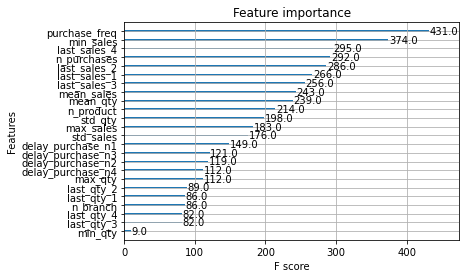

In [44]:
pipeline.steps[1][1].get_booster().feature_names = [name.split('__')[1] for name in pipeline.steps[0][1].get_feature_names_out()]

plot_importance(pipeline.steps[1][1])

## Interpretability

In [45]:
import shap

In [46]:
# load JS visualization code to notebook
shap.initjs()

In [47]:
explainer = shap.TreeExplainer(pipeline.steps[1][1])
shap_values = explainer.shap_values(pipeline.steps[0][1].fit_transform(train_set))

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


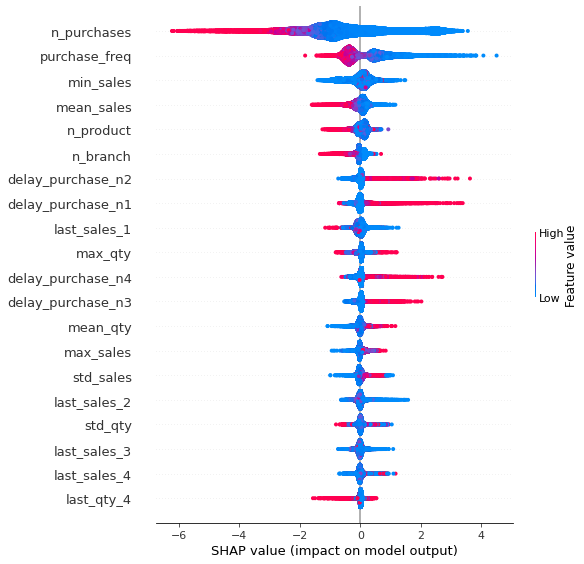

In [48]:
shap.summary_plot(shap_values, features=pipeline.steps[0][1].fit_transform(train_set), 
                  feature_names=[name.split('__')[1] for name in pipeline.steps[0][1].get_feature_names_out()])

In [49]:
i = np.argwhere(train_pred==1)[0][0]
shap.force_plot(
    explainer.expected_value, 
    shap_values[i], 
    features=pipeline.steps[0][1].fit_transform(train_set)[i], 
    feature_names=[name.split('__')[1] for name in pipeline.steps[0][1].get_feature_names_out()]
)

## Validation

In [50]:
# retrieve non-churners
val_transactions = pd.read_csv(os.path.join('..', cst.VALIDATION_DATA_PATH), index_col=0)
non_churners = val_transactions['client_id'].unique()

In [51]:
# check whether a client has churned in the validation period
train_set.loc[train_set['client_id'].isin(non_churners), 'val_is_churn'] = 0
train_set.loc[~(train_set['client_id'].isin(non_churners)), 'val_is_churn'] = 1

In [52]:
train_set['val_is_churn'].value_counts(normalize=True)

0.0    0.783299
1.0    0.216701
Name: val_is_churn, dtype: float64

In [53]:
print(f"Accuracy score: {accuracy_score(train_pred, train_set['val_is_churn'])}")
print(f"Precision score: {precision_score(train_pred, train_set['val_is_churn'])}")
print(f"Recall score: {recall_score(train_pred, train_set['val_is_churn'])}")
print(f"F1 score: {f1_score(train_pred, train_set['val_is_churn'])}")
print(f"{confusion_matrix(train_pred, train_set['val_is_churn'])}")

Accuracy score: 0.8554123444877141
Precision score: 0.5946246819338422
Recall score: 0.6942716553709034
F1 score: 0.640596222212704
[[42165  5098]
 [ 3293  7478]]


## Saving predictions

In [54]:
full_training_data['churn_prob'] = pipeline.predict_proba(full_training_data)[:, 1]
full_training_data['churn_pred'] = pipeline.predict(full_training_data)

In [55]:
full_training_data.loc[(full_training_data['client_id'].isin(non_churners)) & (full_training_data['churn_pred']==1), 'actionable'] = 1

In [36]:
full_training_data.to_csv(os.path.join('..', cst.FULL_PREDICTIONS_PATH))

In [56]:
explainer = shap.TreeExplainer(pipeline.steps[1][1])
shap_values = explainer.shap_values(pipeline.steps[0][1].fit_transform(full_training_data))

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [59]:
np.save(os.path.join('..', cst.SHAP_VALUES_PATH), shap_values)

In [62]:
import pickle

with open(os.path.join('..', cst.EXPLAINER_PATH), 'wb') as f:
    pickle.dump(explainer, f)

In [64]:
with open(os.path.join('..', cst.PIPELINE_PATH), 'wb') as f:
    pickle.dump(pipeline, f)

In [56]:
full_training_data[full_training_data['actionable']==1]

,client_id,mean_qty,max_qty,min_qty,std_qty,last_qty_1,last_qty_2,last_qty_3,last_qty_4,mean_sales,...,client_age,time_from_last_purchase,client_lifetime,last_purchase,frequency,client_category,is_churn,churn_prob,churn_pred,actionable
14,84,11.857143,41,3,10.946423,3,5.0,41.0,3.0,45.973298,...,145.0,101.0,44.0,2019-06-13,14.666667,med_buyer,0.0,0.658525,1.0,1.0
33,373,99.186047,401,3,137.813410,3,3.0,101.0,3.0,139.317990,...,720.0,290.0,430.0,2018-12-06,30.714286,med_buyer,1.0,0.524756,1.0,1.0
155,2238,111.200000,285,3,90.057989,201,285.0,31.0,3.0,6181.752934,...,108.0,96.0,12.0,2019-06-18,4.000000,freq_buyer,0.0,0.566687,1.0,1.0
171,2499,61.491803,401,3,93.375697,201,13.0,7.0,201.0,332.953077,...,667.0,199.0,468.0,2019-03-07,19.500000,med_buyer,1.0,0.637113,1.0,1.0
240,3379,16.163265,361,3,48.576371,5,5.0,3.0,15.0,210.085559,...,390.0,370.0,20.0,2018-09-17,2.500000,freq_buyer,1.0,0.779705,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163639,2271161,95.733333,601,3,165.791769,3,3.0,3.0,3.0,62.867069,...,711.0,446.0,265.0,2018-07-03,22.083333,med_buyer,1.0,0.636817,1.0,1.0
163656,2271419,51.297297,1661,3,198.938190,3,3.0,101.0,3.0,127.674233,...,682.0,227.0,455.0,2019-02-07,16.250000,med_buyer,1.0,0.532243,1.0,1.0
163689,2271853,38.750000,201,3,65.065155,201,5.0,3.0,201.0,62.192589,...,117.0,107.0,10.0,2019-06-07,3.333333,freq_buyer,0.0,0.635145,1.0,1.0
163706,2272077,58.888889,401,3,132.802325,7,5.0,3.0,3.0,162.170732,...,416.0,408.0,8.0,2018-08-10,8.000000,freq_buyer,1.0,0.854980,1.0,1.0
